In [1]:
import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
from normalized_env import NormalizedEnv
from evaluator import Evaluator
from ddpg import DDPG
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#from wolp import WOLPAgent
from util import *
#from ContinuousCartPole import ContinuousCartPoleEnv
from environ import Environ
from tensorboardX import SummaryWriter


In [2]:
def train(num_iterations, agent, env,  evaluate, validate_steps, output, max_episode_length=None, debug=False):

    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0.
    observation = None
    
    #################################### My Code ##############################
    VALUE_loss = []
    POLICE_loss = []
    REWARD = []
    Q_VALUE = []
    TARGET_Q_VALUE = []
    REWARD2 = []
    #################################### My Code ##############################   
    
    while step < num_iterations:  #训练多少轮
        # reset if it is the start of episode
        if observation is None:
            observation = deepcopy(env.reset())  #每个episode要reset一下
            agent.reset(observation)

        # agent pick action ...        
        if step <= args.warmup:   #在warmup步之前随机选择动作，增加探索
            action = agent.random_action()
        else:
            action = agent.select_action(observation)
        
        # env response with next_observation, reward, terminate_info
        observation2, reward, done, info = env.step(action)  #下一个状态……
        observation2 = deepcopy(observation2)
        if max_episode_length and episode_steps >= max_episode_length -1:
            done = True

        REWARD2.append(reward)
        
            
            
            
        # agent observe and update policy
        agent.observe(reward, observation2, done)
        if step > args.warmup:
            agent.update_policy()
            
            value_loss = agent.get_value_loss()
            value_loss = value_loss.detach().numpy()
            VALUE_loss.append(value_loss)
            
            policy_loss = agent.get_policy_loss()
            policy_loss = policy_loss.detach().numpy()
            POLICE_loss.append(policy_loss)
            
            reward1 = agent.get_reward_batch()
            REWARD.append(reward1[0][0])
            
            q_value = agent.get_q_batch()
            q_value = q_value.detach().numpy()
            Q_VALUE.append(q_value[0][0])
            
            target_q_value = agent.get_target_q_batch()
            target_q_value = target_q_value.detach().numpy()
            TARGET_Q_VALUE.append(target_q_value[0][0])
            
        
        # [optional] evaluate   定时的  看一下训练的网络怎么样了
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False)
            if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        # [optional] save intermideate model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)

        # update 
        step += 1
        episode_steps += 1
        episode_reward += reward
        observation = deepcopy(observation2)

        if done: # end of episode
            if debug: prGreen('#{}: episode_reward:{} steps:{}'.format(episode,episode_reward,step))

            agent.memory.append(
                observation,
                agent.select_action(observation),
                0., False
            )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0.
            episode += 1
    
    writer = SummaryWriter('runs/scalar_result')
    for i in range(len(POLICE_loss)):
        writer.add_scalar('POLICE_loss', POLICE_loss[i] , i)
    for i in range(len(VALUE_loss)):
        writer.add_scalar('VALUE_loss', VALUE_loss[i] , i)
    for i in range(len(REWARD)):
        writer.add_scalar('REWARD', REWARD[i] , i)
    for i in range(len(Q_VALUE)):
        writer.add_scalar('Q_VALUE', Q_VALUE[i] , i)
    for i in range(len(TARGET_Q_VALUE)):
        writer.add_scalar('TARGET_Q_VALUE', TARGET_Q_VALUE[i] , i)
    for i in range(len(REWARD2)):
        writer.add_scalar('REWARD2', REWARD2[i] , i)
   

In [3]:
def test(num_episodes, agent, env, evaluate, model_path, visualize=True, debug=False):

    agent.load_weights(model_path)
    agent.is_training = False
    agent.eval()
    policy = lambda x: agent.select_action(x, decay_epsilon=False)

    for i in range(num_episodes):
        validate_reward = evaluate(env, policy, debug=debug, visualize=visualize, save=False)
        if debug: prYellow('[Evaluate] #{}: mean_reward:{}'.format(i, validate_reward))

In [4]:
class Arguments(object):
    def __init__(self):
        '''
        self.mode = 'train'
        self.env = "InvertedPendulum-v2"
        self.hidden1 = 400
        self.hidden2 = 300
        self.rate = 0.001
        self.prate = 0.0001
        self.warmup = 100
        self.discount = 0.99
        self.bsize = 64
        self.rmsize = 6000000
        self.window_length = 1
        self.tau = 0.001
        self.ou_theta = 0.15
        self.ou_sigma = 0.2
        self.ou_mu = 0.0
        self.validate_episodes = 20
        self.max_episode_length = 500
        self.validate_steps = 2000
        self.output = 'output'
        self.debug='debug'
        self.init_w = 0.003
        self.train_iter=20000
        self.epsilon=50000
        self.seed=-1
        self.max_actions=1e6
        self.resume='default'
        self.k_ratio = 1e-6
        '''
        self.mode = 'train'
        self.env = "InvertedPendulum-v2"
        self.hidden1 = 400
        self.hidden2 = 300
        self.rate = 0.001
        self.prate = 0.0001
        self.warmup = 100
        self.discount = 0.99
        self.bsize = 64
        self.rmsize = 6000000
        self.window_length = 1
        self.tau = 0.001
        self.ou_theta = 0.15
        self.ou_sigma = 0.2
        self.ou_mu = 0.0
        self.validate_episodes = 20
        self.max_episode_length = 12
        self.validate_steps = 200
        self.output = 'output'
        self.debug='debug'
        self.init_w = 0.003
        self.train_iter=1000
        self.epsilon=2000
        self.seed=-1
        self.max_actions=1e6
        self.resume='default'
        self.k_ratio = 1e-6

args = Arguments()

F:\Users\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 243 [-5.0, 1.0, -5.0, -4.0, 1.0] [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, -1, -1, -1, -1, -1]


D:\downloads\myExperiment\model.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


1 243 [1.0, 1.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, -1, -1, -1, -1]
2 243 [1.0, 1.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, -1, -1, -1, -1]
3 243 [1.0, 1.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, -1, -1, -1, -1]
4 243 [1.0, 7.0, 1.0, -4.0, 7.0] [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] [0, 6, 1, -1, -1, -1]
5 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] [0, 6, 1, 9, -1, -1]
6 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]
7 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]
8 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]
9 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]
10 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]
11 243 [7.0, 7.0, 1.0, -4.0, 7.0] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] [0, 6, 1, 9, -1, -1]


F:\Users\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: 
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


 [Evaluate] Step_0000000: mean_reward:6.8
 #0: episode_reward:-13.0 steps:2
 #1: episode_reward:-1.0 steps:3
 #2: episode_reward:-1.0 steps:4
 #3: episode_reward:-1.0 steps:5
 #4: episode_reward:-1.0 steps:6
 #5: episode_reward:-1.0 steps:7
 #6: episode_reward:-1.0 steps:8
 #7: episode_reward:-1.0 steps:9
 #8: episode_reward:-1.0 steps:10
 #9: episode_reward:-1.0 steps:11
 #10: episode_reward:-1.0 steps:12
 #11: episode_reward:-1.0 steps:13
 #12: episode_reward:-1.0 steps:14
 #13: episode_reward:-1.0 steps:15
 #14: episode_reward:-1.0 steps:16
 #15: episode_reward:-1.0 steps:17
 #16: episode_reward:-1.0 steps:18
 #17: episode_reward:-1.0 steps:19
 #18: episode_reward:-1.0 steps:20
 #19: episode_reward:-1.0 steps:21
 #20: episode_reward:-1.0 steps:22
 #21: episode_reward:-1.0 steps:23
 #22: episode_reward:-1.0 steps:24
 #23: episode_reward:-1.0 steps:25
 #24: episode_reward:-1.0 steps:26
 #25: episode_reward:-1.0 steps:27
 #26: episode_reward:-1.0 steps:28
 #27: episode_reward:-1.0 step

D:\downloads\myExperiment\util.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(
D:\downloads\myExperiment\ddpg.py:81: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile=False


 #100: episode_reward:-1.0 steps:102
 #101: episode_reward:-1.0 steps:103
 #102: episode_reward:-1.0 steps:104
 #103: episode_reward:-1.0 steps:105
 #104: episode_reward:-1.0 steps:106
 #105: episode_reward:-1.0 steps:107
 #106: episode_reward:-1.0 steps:108
 #107: episode_reward:-1.0 steps:109
 #108: episode_reward:-1.0 steps:110
 #109: episode_reward:-1.0 steps:111
 #110: episode_reward:-1.0 steps:112
 #111: episode_reward:-1.0 steps:113
 #112: episode_reward:-1.0 steps:114
 #113: episode_reward:-1.0 steps:115
 #114: episode_reward:-1.0 steps:116
 #115: episode_reward:-1.0 steps:117
 #116: episode_reward:-1.0 steps:118
 #117: episode_reward:-1.0 steps:119
 #118: episode_reward:-1.0 steps:120
 #119: episode_reward:-1.0 steps:121
 #120: episode_reward:-1.0 steps:122
 #121: episode_reward:-1.0 steps:123
 #122: episode_reward:-1.0 steps:124
 #123: episode_reward:-1.0 steps:125
 #124: episode_reward:-1.0 steps:126
 #125: episode_reward:-1.0 steps:127
 #126: episode_reward:-1.0 steps:128
 

 #278: episode_reward:-1.0 steps:280
 #279: episode_reward:-1.0 steps:281
 #280: episode_reward:-1.0 steps:282
 #281: episode_reward:-1.0 steps:283
 #282: episode_reward:-1.0 steps:284
 #283: episode_reward:-1.0 steps:285
 #284: episode_reward:-1.0 steps:286
 #285: episode_reward:-1.0 steps:287
 #286: episode_reward:-1.0 steps:288
 #287: episode_reward:-1.0 steps:289
 #288: episode_reward:-1.0 steps:290
 #289: episode_reward:-1.0 steps:291
 #290: episode_reward:-1.0 steps:292
 #291: episode_reward:-1.0 steps:293
 #292: episode_reward:-1.0 steps:294
 #293: episode_reward:-1.0 steps:295
 #294: episode_reward:-1.0 steps:296
 #295: episode_reward:-1.0 steps:297
 #296: episode_reward:-1.0 steps:298
 #297: episode_reward:-1.0 steps:299
 #298: episode_reward:-1.0 steps:300
 #299: episode_reward:-1.0 steps:301
 #300: episode_reward:-1.0 steps:302
 #301: episode_reward:-1.0 steps:303
 #302: episode_reward:-1.0 steps:304
 #303: episode_reward:-1.0 steps:305
 #304: episode_reward:-1.0 steps:306
 

 #451: episode_reward:-1.0 steps:453
 #452: episode_reward:-1.0 steps:454
 #453: episode_reward:-1.0 steps:455
 #454: episode_reward:-1.0 steps:456
 #455: episode_reward:-1.0 steps:457
 #456: episode_reward:-1.0 steps:458
 #457: episode_reward:-1.0 steps:459
 #458: episode_reward:-1.0 steps:460
 #459: episode_reward:-1.0 steps:461
 #460: episode_reward:-1.0 steps:462
 #461: episode_reward:-1.0 steps:463
 #462: episode_reward:-1.0 steps:464
 #463: episode_reward:-1.0 steps:465
 #464: episode_reward:-1.0 steps:466
 #465: episode_reward:-1.0 steps:467
 #466: episode_reward:-1.0 steps:468
 #467: episode_reward:-1.0 steps:469
 #468: episode_reward:-1.0 steps:470
 #469: episode_reward:-1.0 steps:471
 #470: episode_reward:-1.0 steps:472
 #471: episode_reward:-1.0 steps:473
 #472: episode_reward:-1.0 steps:474
 #473: episode_reward:-1.0 steps:475
 #474: episode_reward:-1.0 steps:476
 #475: episode_reward:-1.0 steps:477
 #476: episode_reward:-1.0 steps:478
 #477: episode_reward:-1.0 steps:479
 

 #630: episode_reward:-1.0 steps:632
 #631: episode_reward:-1.0 steps:633
 #632: episode_reward:-1.0 steps:634
 #633: episode_reward:-1.0 steps:635
 #634: episode_reward:-1.0 steps:636
 #635: episode_reward:-1.0 steps:637
 #636: episode_reward:-1.0 steps:638
 #637: episode_reward:-1.0 steps:639
 #638: episode_reward:-1.0 steps:640
 #639: episode_reward:-1.0 steps:641
 #640: episode_reward:-1.0 steps:642
 #641: episode_reward:-1.0 steps:643
 #642: episode_reward:-1.0 steps:644
 #643: episode_reward:-1.0 steps:645
 #644: episode_reward:-1.0 steps:646
 #645: episode_reward:-1.0 steps:647
 #646: episode_reward:-1.0 steps:648
 #647: episode_reward:-1.0 steps:649
 #648: episode_reward:-1.0 steps:650
 #649: episode_reward:-1.0 steps:651
 #650: episode_reward:-1.0 steps:652
 #651: episode_reward:-1.0 steps:653
 #652: episode_reward:-1.0 steps:654
 #653: episode_reward:-1.0 steps:655
 #654: episode_reward:-1.0 steps:656
 #655: episode_reward:-1.0 steps:657
 #656: episode_reward:-1.0 steps:658
 

 #804: episode_reward:-1.0 steps:806
 #805: episode_reward:-1.0 steps:807
 #806: episode_reward:-1.0 steps:808
 #807: episode_reward:-1.0 steps:809
 #808: episode_reward:-1.0 steps:810
 #809: episode_reward:-1.0 steps:811
 #810: episode_reward:-1.0 steps:812
 #811: episode_reward:-1.0 steps:813
 #812: episode_reward:-1.0 steps:814
 #813: episode_reward:-1.0 steps:815
 #814: episode_reward:-1.0 steps:816
 #815: episode_reward:-1.0 steps:817
 #816: episode_reward:-1.0 steps:818
 #817: episode_reward:-1.0 steps:819
 #818: episode_reward:-1.0 steps:820
 #819: episode_reward:-1.0 steps:821
 #820: episode_reward:-1.0 steps:822
 #821: episode_reward:-1.0 steps:823
 #822: episode_reward:-1.0 steps:824
 #823: episode_reward:-1.0 steps:825
 #824: episode_reward:-1.0 steps:826
 #825: episode_reward:-1.0 steps:827
 #826: episode_reward:-1.0 steps:828
 #827: episode_reward:-1.0 steps:829
 #828: episode_reward:-1.0 steps:830
 #829: episode_reward:-1.0 steps:831
 #830: episode_reward:-1.0 steps:832
 

 #982: episode_reward:-1.0 steps:984
 #983: episode_reward:-1.0 steps:985
 #984: episode_reward:-1.0 steps:986
 #985: episode_reward:-1.0 steps:987
 #986: episode_reward:-1.0 steps:988
 #987: episode_reward:-1.0 steps:989
 #988: episode_reward:-1.0 steps:990
 #989: episode_reward:-1.0 steps:991
 #990: episode_reward:-1.0 steps:992
 #991: episode_reward:-1.0 steps:993
 #992: episode_reward:-1.0 steps:994
 #993: episode_reward:-1.0 steps:995
 #994: episode_reward:-1.0 steps:996
 #995: episode_reward:-1.0 steps:997
 #996: episode_reward:-1.0 steps:998
 #997: episode_reward:-1.0 steps:999
 #998: episode_reward:-1.0 steps:1000


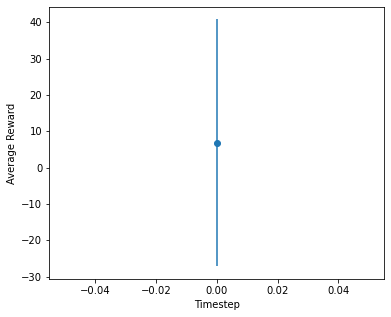

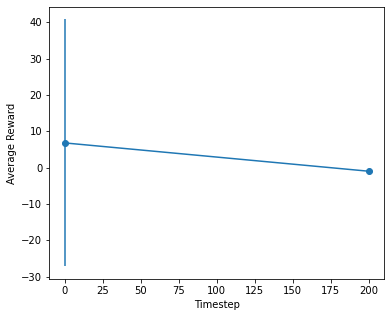

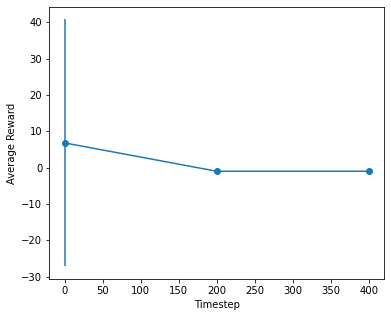

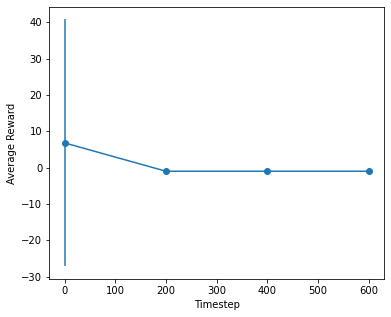

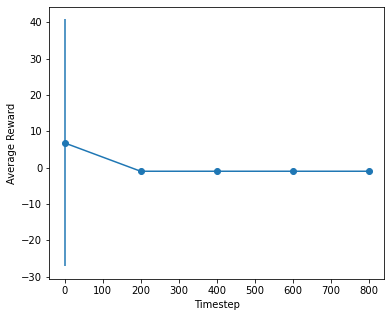

In [5]:
args.output = get_output_folder(args.output, args.env)
if args.resume == 'default':
    args.resume = 'output/{}-run0'.format(args.env)

# env = NormalizedEnv(gym.make(args.env))
# env = gym.make(args.env)
env = Environ()
#################################### Our Code ##############################
args.low = env.action_space.low
args.high = env.action_space.high
#################################### Our Code ##############################

if args.seed > 0:
    np.random.seed(args.seed)
    env.seed(args.seed)

nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]


agent = DDPG(nb_states, nb_actions, args)
evaluate = Evaluator(args.validate_episodes, 
    args.validate_steps, args.output, max_episode_length=args.max_episode_length)

start_time = time.time()

if args.mode == 'train':
    train(args.train_iter, agent, env, evaluate, 
        args.validate_steps, args.output, max_episode_length=args.max_episode_length, debug=args.debug)
    end_time = time.time()

elif args.mode == 'test':
    test(args.validate_episodes, agent, env, evaluate, args.resume,
        visualize=True, debug=args.debug)

else:
    raise RuntimeError('undefined mode {}'.format(args.mode))